## Linear Regression

The goal of this notebook is to build a **baseline regression model** to predict medical insurance charges based on demographic and lifestyle factors such as age, BMI, smoking status, and number of dependents.

Linear Regression is used as an **interpretable baseline model** to understand the linear relationship between predictors and insurance charges.


## 1) Importing Required Libraries and Dependencies

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.chdir('D:/ds/ml/Medical_Insurance_Cost-main')

## 2) Dataset Loading and Initial Inspection

The insurance dataset contains demographic, lifestyle, and regional attributes of individuals along with their corresponding medical insurance charges.  
Initial inspection is performed to understand the structure, data types, and completeness of the dataset.


In [3]:
df=pd.read_csv('insurance.csv')

In [4]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
df.region.value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

In [6]:
df.sex.value_counts()

sex
male      676
female    662
Name: count, dtype: int64

In [7]:
df.smoker.value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

In [8]:
df.nunique()

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

## 3) Target Variable Distribution (Medical Insurance Charges)

Text(0.5, 1.0, 'Distribution Of Medical Insrance Charges')

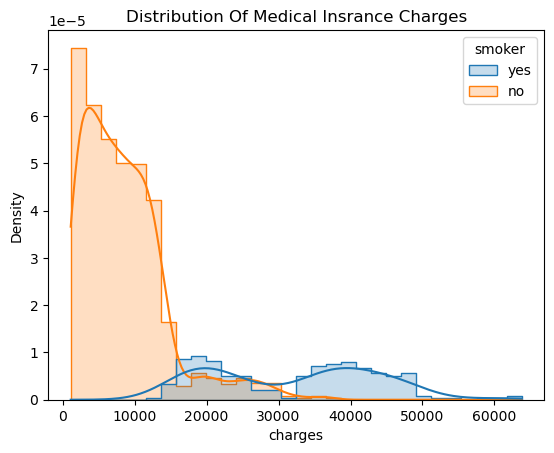

In [9]:
sns.histplot(
    data=df,
    x='charges',
    kde=True,
    hue='smoker',
    stat='density',
    element='step'
)
plt.title("Distribution Of Medical Insrance Charges")

The target variable `charges` represents medical insurance costs.  
Its distribution is **right-skewed**, which violates the normality assumption of linear regression.

To stabilize variance and improve model performance, a **log transformation** of the target variable is applied.

In [10]:
df['log_charges'] = np.log(df['charges'])
df[['charges', 'log_charges']].head()

,charges,log_charges
0,16884.92400,9.734176
1,1725.55230,7.453302
2,4449.46200,8.400538
3,21984.47061,9.998092
4,3866.85520,8.260197


Text(0.5, 1.0, 'Log Charges Distribution')

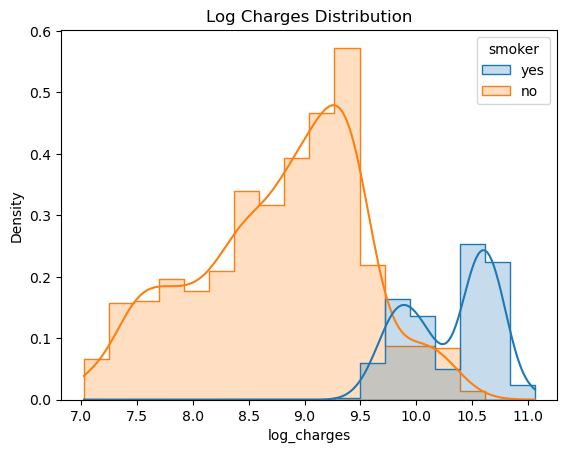

In [11]:
sns.histplot(
    data=df,
    x='log_charges',
    kde=True,
    stat='density',
    hue='smoker',
    element='step'
)
plt.title("Log Charges Distribution")

## 4) Features and Targets

In [12]:
# Features
X = df.drop(['charges', 'log_charges'], axis=1)

# Target
y = df['log_charges']

## 5) Categorical Feature Encoding

The dataset contains both numerical and categorical variables.  
Since machine learning models require numerical inputs, categorical variables must be encoded appropriately.

To avoid introducing artificial ordering and data leakage, categorical variables are encoded using **One-Hot Encoding** within a preprocessing pipeine.
.


### 5(a) Identifying Categorical & Numerical Columns

In [13]:
# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove target variables from numerical list
numerical_cols.remove('charges')
numerical_cols.remove('log_charges')

In [14]:
print("Categorical Features : ",categorical_cols)
print("Numerical Features : ", numerical_cols)

Categorical Features :  ['sex', 'smoker', 'region']
Numerical Features :  ['age', 'bmi', 'children']


#### **Numerical & Categorical Features and Target**
- Numerical features : `['age', 'bmi', 'children']`
- Categorical Features : `['sex', 'smoker', 'region']`
- Target : `['log_charges']`

### 5(b) Column Transformer

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('num', MinMaxScaler(), numerical_cols)
    ]
)

## 6) Pipeline with Linear Regression

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

lr_model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', LinearRegression())
])

## 7) Train-Test-Split

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

## 8) Model Training
A Multiple Linear Regression model is trained to learn the linear relationship between predictors and the log-transformed insurance charges.

In [18]:
lr_model.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


The original dataset remains unchanged because sklearn pipelines apply transformations internally and pass a transformed numeric array to the model. This design prevents data leakage and ensures reproducibility.

## 9) Model Evaluation
The model is evaluated using:- **R2 Score**: Measures explained variance
- **RMSE**: Measures average prediction error

In [19]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

y_pred = lr_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R2 Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

R2 Score: 0.805
RMSE: 0.419


## 10) Residual Analysis

Residual analysis is performed to validate key assumptions of linear regression:
- Linearity
- Homoscedasticity
- Independence of errors

Text(0.5, 1.0, 'Residuals vs Predicted Values')

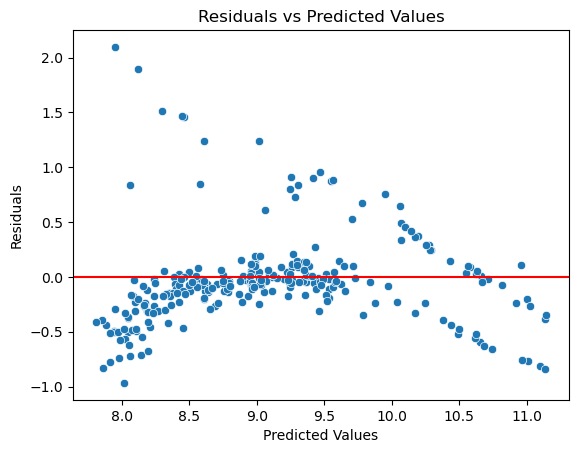

In [20]:
residuals = y_test - y_pred

import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")

## 11) Model Coefficients Interpretation

Linear regression coefficients help interpret the **direction and magnitude** of each feature’s impact on insurance cost.

In [21]:
cat_features = lr_model.named_steps['preprocessing'] \
    .named_transformers_['cat'] \
    .get_feature_names_out(categorical_cols)

In [22]:
feature_names = list(cat_features) + numerical_cols

In [23]:
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_model.named_steps['regressor'].coef_
}).sort_values(by='Coefficient', ascending=False)

coef_df

,Feature,Coefficient
5,age,1.575292
1,smoker_yes,1.551698
6,bmi,0.505505
7,children,0.462239
2,region_northwest,-0.056414
0,sex_male,-0.074350
4,region_southwest,-0.122557
3,region_southeast,-0.136068


In [24]:
intercept = lr_model.named_steps['regressor'].intercept_
print(f"Intercept: {intercept:.3f}")

Intercept: 7.880


## 12) Limitations of Linear Regression

- Assumes linear relationships between variables
- Sensitive to outliers
- Cannot capture complex feature interactions

These limitations motivate the use of tree-based and ensemble models in subsequent noteooks.


## 13) Conclusion

Linear Regression served as a strong **baseline model** for insurance cost prediction.  
While interpretable and simple, its performance is limited by linear assumptions, leading to the exploration of more advanced non-linear models in later stages.
